In [1]:
import numpy as np
import random

# Set a global random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
"""QUANT: A Minimalist Interval Method for Time Series Classification."""

import numpy as np
from sklearn.ensemble import ExtraTreesClassifier

from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
from aeon.transformations.collection.interval_based import QUANTTransformer


class QUANTClassifier(BaseClassifier):
    """QUANT interval classifier.

    The classifier computes quantiles over a fixed set of dyadic intervals of
    the input series and three transformations of the input time series. For each set of
    intervals extracted, the window is shifted by half the interval length to extract
    more intervals.

    The feature extraction is performed on the first order differences, second order
    differences, and a Fourier transform of the input series along with the original
    series.

    The transform output is then used to train an extra trees classifier by default.

    Parameters
    ----------
    interval_depth : int, default=6
        The depth to stop extracting intervals at. Starting with the full series, the
        number of intervals extracted is ``2 ** depth`` (starting at 0) for each level.
        The features from all intervals extracted at each level are concatenated
        together for the transform output.
    quantile_divisor : int, default=4
        The divisor to find the number of quantiles to extract from intervals. The
        number of quantiles per interval is
        ``1 + (interval_length - 1) // quantile_divisor``.
    estimator : sklearn estimator, default=None
        The estimator to use for classification. If None, an ExtraTreesClassifier
        with 200 estimators is used.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None, and the default ExtraTreesClassifier is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    See Also
    --------
    QUANTTransformer

    Notes
    -----
    Original code: https://github.com/angus924/quant

    References
    ----------
    .. [1] Dempster, A., Schmidt, D.F. and Webb, G.I., 2023. QUANT: A Minimalist
        Interval Method for Time Series Classification. arXiv preprint arXiv:2308.00928.

    Examples
    --------
    >>> from aeon.classification.interval_based import QUANTClassifier
    >>> from aeon.testing.data_generation import make_example_3d_numpy
    >>> X, y = make_example_3d_numpy(n_cases=10, n_channels=1, n_timepoints=12,
    ...                              random_state=0)
    >>> clf = QUANTClassifier()  # doctest: +SKIP
    >>> clf.fit(X, y)  # doctest: +SKIP
    QUANTClassifier()
    >>> clf.predict(X)  # doctest: +SKIP
    array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])
    """

    _tags = {
        "capability:multivariate": True,
        "algorithm_type": "interval",
        "python_dependencies": "torch",
    }

    def __init__(
        self,
        interval_depth=6,
        quantile_divisor=4,
        estimator=None,
        class_weight=None,
        random_state=None,
    ):
        self.interval_depth = interval_depth
        self.quantile_divisor = quantile_divisor
        self.estimator = estimator
        self.class_weight = class_weight
        self.random_state = random_state
        super().__init__()

    def _fit(self, X, y):
        """Fit the estimator to training data.

        Parameters
        ----------
        X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
            The training data.
        y : 1D np.ndarray of shape (n_cases)
            The class labels for fitting, indices correspond to instance indices in X

        Returns
        -------
        self :
            Reference to self.
        """
        self._transformer = QUANTTransformer(
            interval_depth=self.interval_depth,
            quantile_divisor=self.quantile_divisor,
        )

        self._estimator = _clone_estimator(
            (
                ExtraTreesClassifier(
                    n_estimators=200,
                    max_features=0.1,
                    criterion="entropy",
                    class_weight=self.class_weight,
                    random_state=self.random_state,
                )
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        X_t = self._transformer.fit_transform(X, y)
        self._estimator.fit(X_t, y)

        return self

    def _predict(self, X):
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.array of shape (n_cases, n_channels, n_timepoints)
            The testing data.

        Returns
        -------
        y : array-like of shape (n_cases)
            Predicted class labels.
        """
        return self._estimator.predict(self._transformer.transform(X))

    def _predict_proba(self, X):
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.array of shape (n_cases, n_channels, n_timepoints)
            The testing data.

        Returns
        -------
        y : array-like of shape (n_cases, n_classes_)
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self._estimator.predict_proba(self._transformer.transform(X))
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self._estimator.predict(self._transformer.transform(X))
            for i in range(0, X.shape[0]):
                dists[i, self._class_dictionary[preds[i]]] = 1
            return dists

In [3]:
import os
import numpy as np
import librosa

def load_data_from_directory(directory, sample_length=16000, n_channels=1):
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}  # Create a label to index mapping

    total_files = 0  # Initialize a counter for total files

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            file_count = 0  # Counter for files in the current class directory
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_count += 1  # Increment file count for the current class
                    file_path = os.path.join(class_dir, file_name)
                    # Load audio
                    signal, sr = librosa.load(file_path, sr=16000)
                    # Ensure length is 1 second (16000 samples)
                    if len(signal) != sample_length:
                        # Pad or truncate to sample_length
                        if len(signal) < sample_length:
                            signal = np.pad(signal, (0, sample_length - len(signal)))
                        else:
                            signal = signal[:sample_length]
                    # Reshape signal to match (n_channels, n_timepoints)
                    X.append(signal.reshape(n_channels, -1))  # Reshape to (1, sample_length)
                    y.append(label_map[label])  # Use the index of the label

            total_files += file_count  # Add the current class file count to the total
            print(f"Total number of files in folder '{label}': {file_count}")

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(X.shape)
    print(y.shape)
    print(y)
    print(f"Overall total number of files in the dataset: {total_files}")

    return X, y, labels

# Load and preprocess data
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_from_directory(directory)


Total number of files in folder 'down': 2359
Total number of files in folder 'go': 2372
Total number of files in folder 'left': 2353
Total number of files in folder 'no': 2375
Total number of files in folder 'off': 2357
Total number of files in folder 'on': 2367
Total number of files in folder 'right': 2367
Total number of files in folder 'silence': 2010
Total number of files in folder 'stop': 2380
Total number of files in folder 'unknown': 2000
Total number of files in folder 'up': 2375
Total number of files in folder 'yes': 2377
(27692, 1, 16000)
(27692,)
[ 0  0  0 ... 11 11 11]
Overall total number of files in the dataset: 27692


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:



# Split data into training and testing sets with a fixed random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)






In [6]:
# Initialize the Classifier

clf = QUANTClassifier(
    random_state=SEED
)







In [7]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

QUANTClassifier(random_state=42)

In [8]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.6625744719263404


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.6726381031325993
Recall (macro): 0.6671518142922993
F1 Score (macro): 0.6580785091990143


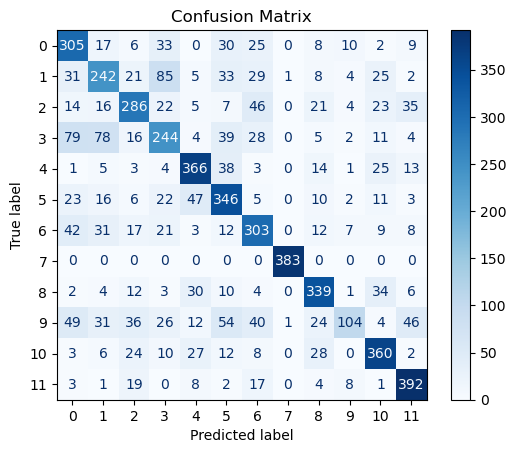

In [10]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


